In [1]:
import os
import pandas as pd
import numpy as np
import math as math
import scipy.stats as stats
from scipy.stats import expon
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.stats import norm

##Expected shortfall

Average of the $[(1 - c) * n]$ worst realizations

 Derive a formula for the expected shortfall if gains are normally distributed $N(\mu, \sigma^{2})$.

Normal Distribution:
\begin{equation}
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
\end{equation}

\begin{equation}
F(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\int_{-\infty}^x e^{-\frac{(t-\mu)^2}{2\sigma^2}} dt
\end{equation}

$$E[X] = \mu, Var[X] = \sigma^2$$

Expected Shortfall:\begin{align*}
ES_{\alpha} &= W_0-E[W|W<W_0-VAR]\\
& = W_0-\frac{\int_{-\infty}^{W_0-VAR}Wf(W)dW}{\int_{-\infty}^{W_0-VAR}f(W)dW}\\
\end{align*}

Derive the formula: Let \begin{align*}
y = \frac{x-\mu}{\sigma}
\end{align*}
We can get \begin{align*}
dy = \frac{dx}{\sigma}, x = {\sigma}y + \mu, dx = {\sigma}dy
\end{align*}
Then
$$
\begin{aligned}
ES_{\alpha} &=\frac{1}{\sqrt{2 \pi \sigma^2}} \int_{-\infty}^{\mu-VaR_\alpha} x \cdot \exp \left(-\frac{(x-\mu)^2}{2 \sigma^2}\right) d x \\
= & \frac{1}{\sqrt{2 \pi \sigma^2}} \int(\sigma y+\mu) \cdot \exp \left(-\frac{(\sigma y+\mu-\mu)^2}{2 \sigma^2}\right) \sigma d y \\
= & \frac{1}{\sqrt{2 \pi \sigma^2}} \int(\sigma y+\mu) \exp \left(-\frac{y^2}{2}\right) \sigma d y \\
= & \frac{1}{\sqrt{2 \pi \sigma^2}} \int \sigma^2 y \exp \left(-\frac{y^2}{2}\right) d y+\frac{1}{\sqrt{2 \pi \sigma^2}} \int \sigma \mu \exp \left(-\frac{y^2}{2}\right) d y \\
= & \mu \int_{-\infty}^{y_0-V a R_{(0,1)}} \frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{y^2}{2}\right) d y+\sigma \int_{-\infty}^{y_0-V a R_{(0,1)}} \frac{1}{\sqrt{2 \pi}} y \exp \left(-\frac{y^2}{2}\right) d y
\end{aligned}
$$
Since
$$\begin{aligned}
y_0 = 0, VaR_\alpha = -z(1-\alpha)=-z(c))
\end{aligned}$$
We continue deriving the above formula, and we can abtain
$$
\begin{aligned}
= & \mu \cdot(1-c)+\left.\sigma \cdot \frac{-1}{\sqrt{2 \pi}} \cdot e^{\frac{-y^2}{2}}\right|_{\infty} ^{z(c)} \\
= & \mu \cdot(1-c)+\sigma \cdot \frac{-1}{\sqrt{2 \pi}} e^{-z(c)^2 / 2}
\end{aligned}
$$
Finally, we can get
$$
E S=y_0-\frac{\mu \cdot(1-c)+\sigma \cdot \frac{-1}{\sqrt{2 \pi}} e^{-z(c)^2 / 2}}{1-c}=-\mu+\sigma \cdot \frac{1}{\sqrt{2 \pi}(1-c)} e^{-z(c)^2 / 2}
$$

The expected shortfall can also be defined as the average of the VaR for all confidence level above c: $ES = \frac{1}{1-c}\int_{c}^{1} VaR_{\alpha}d\alpha$ Prove that this definition is equivalent to the one we have seen in class. Hint: You can use integration by part and a change of variable.

From the definition of VaR and ES, we get
\begin{aligned}
E S & =\frac{1}{1-c} \int_c^1 V a R_\alpha d \alpha \\
& =\frac{1}{1-c} \int_c^1 W_0-F^{-1}(1-\alpha) d \alpha \\
& =W_0-\frac{1}{1-c} \int_c^1 F^{-1}(1-\alpha) d \alpha
\end{aligned}
Cause$$
\begin{aligned}
W=F^{-1}(1-\alpha)
\end{aligned}
$$
We have
$$
d W=-\frac{1}{F^{\prime}\left(F^{-1}(1-\alpha)\right)} d \alpha=-\frac{1}{f\left(F^{-1}(1-\alpha)\right)} d \alpha
$$
Since
$$
d \alpha=-f\left(F^{-1}(1-\alpha)\right) d W=-f(W) d W
$$
and
$$F^{-1}(1-1)=-\infty, F^{-1}(1-c)=W_0-V a R$$
We have
$$
\begin{aligned}
& W_0-\frac{1}{1-c} \int_c^1 F^{-1}(1-\alpha) d \alpha \\
= & W_0-\frac{1}{1-c} \int_{W_0-V a R}^{-\infty}-W f(W) d W \\
= & W_0-\frac{1}{1-c} \int_{-\infty}^{W_0-V a R} W f(W) d W
\end{aligned}
$$

 ## Decomposing the VaR of a portfolio

part 1

Assume you have a portfolio of 2m in asset A, 6m in asset B and 2m in
asset C. What is the VaR of your portfolio? What is the CVaR and DVaR
for each of the assets? Check that the sum of CVaRs coincides with VaR.
Which asset is responsible for the most risk of the portfolio?

**Function draw_returns(N)**

This function simulates returns for a portfolio of three assets over
$𝑁$ periods, distinguishing between normal and special (crisis) years:

*normal_year:* A binomial distribution to simulate 90% normal years and 10% special years.

*normal_ret*: Multivariate normal returns for normal years.

*special_ret*: Multivariate normal returns for special years.

The function then combines these to create a series of returns for the portfolio.

In [2]:
def draw_returns(N):

    # coin flips
    normal_year = np.random.binomial(1, 0.9, N)

    # draw for normal years
    mu = np.array([0.05, 0.05, 0.05])
    Sigma = np.array([[0.09, 0.012, 0.021], [0.012, 0.16, 0.028], [0.021, 0.028, 0.49]])
    normal_ret = np.random.multivariate_normal(mu, Sigma, N)

    # draws for special years
    mu = np.array([-0.1, -0.1, -0.1])
    Sigma = np.array([[0.36, 0.24, 0.42], [0.24, 0.64, 0.56], [0.42, 0.56, 1.96]])
    special_ret = np.random.multivariate_normal(mu, Sigma, N)

    # combine
    ret = normal_ret
    for i in range(N):
        if normal_year[i] == 0:
            ret[i,:] = special_ret[i,:]

    return(ret)

First, for the VaR:

**Portfolio_profit(returns, holdings)**

This function calculates the profit of a portfolio given returns and holdings:
np.dot(returns, holdings): Computes the dot product, which gives the total profit for each set of returns.

**VaR_from_gains(gains, c=0.99)**
This function calculates the Value at Risk (VaR) at confidence level
$c$:

VaR is the maximum expected loss over a given time period at a specific confidence level. It sorts the gains and selects the appropriate quantile based on $c$.

**Portfolio Analysis**

*Initial Holdings:*

holdings_Q1=[2000,6000,2000]

holdings_Q1=[2000,6000,2000]

in thousands of dollars.

**Gains:** Profits from the portfolio given the simulated returns and holdings.

**VaR_Q1**: The Value at Risk for the portfolio with the initial holdings.

Delta VaR (DVaR) Calculations
The effect of increasing the position in each asset by $1000 on VaR:

DVaR_A: Change in VaR when increasing the first asset’s holdings.

DVaR_B: Change in VaR for the second asset.

DVaR_C: Change in VaR for the third asset.

Conditional Value at Risk (CVaR)
CVaR (also called Expected Shortfall) measures the average loss given that the loss exceeds the VaR. It provides a more comprehensive risk measure.

**The calculation:**

Delta: A small increment in asset holdings (0.01 or 1%).

CVaR_A: The conditional VaR for the first asset when its holdings are increased slightly.

**Context:** Value at Risk (VaR) and Conditional Value at Risk (CVaR)
VaR is a threshold value such that the probability that the loss on the portfolio over the given time horizon exceeds this value is the confidence level (e.g., 99%).
CVaR takes this a step further by considering the tail of the loss distribution beyond the VaR, providing a measure of the expected loss in extreme scenarios. It's especially useful in risk management for understanding the potential impact of rare, but severe, losses.

VaR for holdings_Q1: 9956.983483145892
DVaR_A: 0.9310030602446204
DVaR_B: 0.6708504808684665
DVaR_C: 2.034937238724524
CVaR_A: 1862.00612048724
CVaR_B: 4025.1028852100717
CVaR_C: 4069.874477448866
Sum of CVaR deviations: 0.9959291819997494


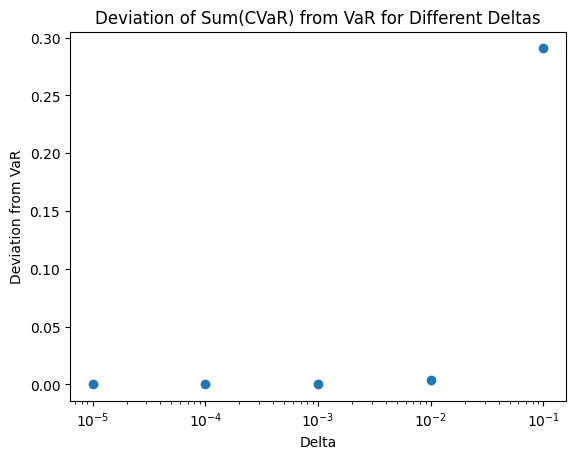

VaR for holdings_Q3: 9565.547422197978
DVaR_C for holdings_Q3: 3.2698732136959734
CVaR_C for holdings_Q3: 6539.746427393948


In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt

np.random.seed(1234)

# Assuming the function draw_returns(N) is defined elsewhere and returns a (N, 3) matrix of simulated returns.
rets = draw_returns(10000)

def portfolio_profit(returns, holdings):
    """
    Calculate the profit of a portfolio given returns and holdings.

    Parameters:
    returns (numpy array): Array of returns.
    holdings (numpy array): Array of holdings in thousands of dollars.

    Returns:
    float: The total profit for the portfolio.
    """
    return np.dot(returns, holdings)

holdings_Q1 = np.array([2000, 6000, 2000])  # in 1000 $

gains = portfolio_profit(rets, holdings_Q1)

def VaR_from_gains(gains, c=0.99):
    """
    Calculate the Value at Risk (VaR) for given portfolio gains at confidence level c.

    Parameters:
    gains (numpy array): Array of portfolio gains.
    c (float): Confidence level for VaR calculation (default is 0.99).

    Returns:
    float: The VaR value.
    """
    n = len(gains)
    sort = sorted(gains)
    VaR = -sort[math.ceil(n * (1 - c)) - 1]
    return VaR

VaR_Q1 = VaR_from_gains(gains)
print("VaR for holdings_Q1:", VaR_Q1)

# Delta VaR (DVaR) Calculations
Delta = 1

# Asset A
VaR_new_A = VaR_from_gains(portfolio_profit(rets, holdings_Q1 + np.array([Delta, 0, 0])))
DVaR_A = (VaR_new_A - VaR_Q1) / Delta
print("DVaR_A:", DVaR_A)

# Asset B
VaR_new_B = VaR_from_gains(portfolio_profit(rets, holdings_Q1 + np.array([0, Delta, 0])))
DVaR_B = (VaR_new_B - VaR_Q1) / Delta
print("DVaR_B:", DVaR_B)

# Asset C
VaR_new_C = VaR_from_gains(portfolio_profit(rets, holdings_Q1 + np.array([0, 0, Delta])))
DVaR_C = (VaR_new_C - VaR_Q1) / Delta
print("DVaR_C:", DVaR_C)

# Conditional Value at Risk (CVaR) Calculations
Delta = 0.01

# Asset A
VaR_new_A = VaR_from_gains(portfolio_profit(rets, holdings_Q1 * np.array([1 + Delta, 1, 1])))
CVaR_A = 100 * (VaR_new_A - VaR_Q1)
print("CVaR_A:", CVaR_A)

# Asset B
VaR_new_B = VaR_from_gains(portfolio_profit(rets, holdings_Q1 * np.array([1, 1 + Delta, 1])))
CVaR_B = 100 * (VaR_new_B - VaR_Q1)
print("CVaR_B:", CVaR_B)

# Asset C
VaR_new_C = VaR_from_gains(portfolio_profit(rets, holdings_Q1 * np.array([1, 1, 1 + Delta])))
CVaR_C = 100 * (VaR_new_C - VaR_Q1)
print("CVaR_C:", CVaR_C)

# Checking the sum of CVaRs against VaR
cvar_sum_deviation = (CVaR_A + CVaR_B + CVaR_C) / VaR_new_C
print("Sum of CVaR deviations:", cvar_sum_deviation)

def deviation(Delta):
    """
    Calculate the deviation between the sum of CVaRs and VaR for different deltas.

    Parameters:
    Delta (float): The small increment in asset holdings.

    Returns:
    float: The deviation value.
    """
    # Asset A
    VaR_new_A = VaR_from_gains(portfolio_profit(rets, holdings_Q1 * np.array([1 + Delta, 1, 1])))
    CVaR_A = (VaR_new_A - VaR_Q1) / Delta

    # Asset B
    VaR_new_B = VaR_from_gains(portfolio_profit(rets, holdings_Q1 * np.array([1, 1 + Delta, 1])))
    CVaR_B = (VaR_new_B - VaR_Q1) / Delta

    # Asset C
    VaR_new_C = VaR_from_gains(portfolio_profit(rets, holdings_Q1 * np.array([1, 1, 1 + Delta])))
    CVaR_C = (VaR_new_C - VaR_Q1) / Delta

    # Return the deviation as a percentage
    return np.abs(CVaR_A + CVaR_B + CVaR_C - VaR_new_C) / VaR_new_C

# Analyze the deviation for different Delta values
Deltas = np.array([0.00001, 0.0001, 0.001, 0.01, 0.1])
deviations = [deviation(Delta) for Delta in Deltas]

plt.plot(Deltas, deviations, 'o')
plt.xscale('log')
plt.xlabel('Delta')
plt.ylabel('Deviation from VaR')
plt.title('Deviation of Sum(CVaR) from VaR for Different Deltas')
plt.show()

# Analysis with different holdings
holdings_Q3 = np.array([3000, 5000, 2000])  # in 1000 $
gains_Q3 = portfolio_profit(rets, holdings_Q3)
VaR_Q3 = VaR_from_gains(gains_Q3)
print("VaR for holdings_Q3:", VaR_Q3)

# DVaR for Asset C with new holdings
Delta = 1
VaR_new_C = VaR_from_gains(portfolio_profit(rets, holdings_Q3 + np.array([0, 0, Delta])))
DVaR_C = (VaR_new_C - VaR_Q3) / Delta
print("DVaR_C for holdings_Q3:", DVaR_C)

# CVaR for Asset C with new holdings
Delta = 0.01
VaR_new_C = VaR_from_gains(portfolio_profit(rets, holdings_Q3 * np.array([1, 1, 1 + Delta])))
CVaR_C = 100 * (VaR_new_C - VaR_Q3)
print("CVaR_C for holdings_Q3:", CVaR_C)


Assuming $W_0$ = 0, the VaR is 9956.983483145892.

Let’s start with DVaR by adding some 1k to the holdings of any one stock.

When you approximate the derivatives involved in DVaR and CVaR, vary
the size of the position change you use. What do you observe when you
change the value? Report a graph that shows the effect of different size of
the step for the derivative. Explain what is happening.

How does this depend on Delta. Below you can see show how large the deviation between the sum of CVaR and VaR is for different levels of Delta 0.001%, 0.01%, 0.1%, 1%, and 10%. The smaller Delta, the more precise the result

what happens when we hold 2mn $ in both asset A and B, vis-a-vis 1mn and 3mn in A and B. In particular, is this going to affect the DVaR or CVaR for asset C (the holdings and portfolio weights of asset C are)

##Managing a Currency Trading Desk

Deutsche Bank (DB) is a German bank that manages its book in EUR. Consider
2 desks in DB, one is long 150 million USD and the other is short 50 million GBP.
The exchange rates are 1 USD = 0.9163 EUR and 1 GBP = 1.3599 EUR. The
daily volatilities for changes in USD/EUR and GBP/EUR are 0.40% and 0.30%,
respectively and means of 1 basis point and 1.5 basis points. The correlation
between them is 0.6. For risk calculations, assume that the returns have mean
zero and are normally distributed.

1. What is the 99% 1-day VaR for each desk?
2. What is the 99% 1-day VaR for the combined portfolio?

Optional, more challenging:
3. Consider an arbitrary portfolio with positions x1 and x2 in two assets.
If you increase your position in x1 by a small amount Δx1, by how much do
you need to change your position in asset 2 to keep your VaR constant? What
is the effect of these changes on your expected profits? Obtain mathematical
expressions as function of (some but not neccesarily all of) Δx1, VaR, DVaR,
CVaR, and expected returns.
4. How would you change the allocation of DB’s trading desk? Give a
quantitative argument.

**Optional, more challenging:**
3. Consider an arbitrary portfolio with positions x1 and x2 in two assets.
If you increase your position in x1 by a small amount Δx1, by how much do
you need to change your position in asset 2 to keep your VaR constant? What
is the effect of these changes on your expected profits? Obtain mathematical
expressions as function of (some but not neccesarily all of) Δx1, VaR, DVaR,
CVaR, and expected returns.
4. How would you change the allocation of DB’s trading desk? Give a
quantitative argument.

Notice

\begin{align}
        \mathbf{R} \mathbf{_{t+1}} \mathbf{^{USDEUR}} =  \frac{\mathbf{E} \mathbf{_{t+1}} \, {^{USDEUR}}}{\mathbf{\mathbf{E}_{t+1}\, {^{USDEUR}} }}-1 \sim N (0.0001, 0.004^2)
    \end{align}